# Connect to TPU/GPU

In [ ]:
import os
import tensorflow as tf

if 'COLAB_TPU_ADDR' in os.environ and os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')

elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
  
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


# Libraries

In [ ]:
# ! pip install transformers
! pip install --no-cache-dir transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 52.4 MB/s 
     |████████████████████████████████| 6.6 MB 39.5 MB/s 
     |████████████████████████████████| 163 kB 59.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
import re
import ast
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import models, layers, callbacks, metrics
from transformers import TFBertForSequenceClassification#, TFTrainer, TFTrainingArguments, AutoModel
from transformers import BertConfig, TFBertModel, BertTokenizer, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [ ]:
def clean_tweet_lite(text):
  
  # lowercase
  text = text.lower()

  # remove links
  regex = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
  text = re.sub(regex, '', text)

  # fix start of tweet
  if text.startswith('rt '): 
    text = text[3:]

  # replace html chars
  text = BeautifulSoup(text).get_text()
  text = text.replace('\x92', '\'') # quotes
  text = text.replace('&lt;', '<').replace('&gt;', '>').replace('&amp;', '&').replace('&#39;', '\'').replace('&#039;', '\'')
  text = text.replace('[', '(').replace(']', ')') # brackets

  # replace users mentions
  text = ' '.join(re.sub("(@[A-Za-z0-9_]+)", "@user", text).split())

  # fix punctuation
  text = text.replace(' . ', '. ').replace(' , ', ', ').replace(' : ', ': ').replace(' ; ', '; ').replace(' ? ', '? ').replace(' ! ', '! ')

  # fix whitespaces
  text = ' '.join(text.split())

  return text


# def clean_tweet_lite(text):
  
#   # lowercase
#   text = text.lower()

#   # remove links
#   regex = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
#   text = re.sub(regex, '', text).strip()

#   # replace html chars
#   text = BeautifulSoup(text).get_text()
#   text = text.replace('\x92', '\'') # quotes
#   text = text.replace('[', '(').replace(']', ')') # brackets

#   # replace errors on accents and contractions
#   text = text.replace('e\'', 'è').replace('a\'', 'à').replace('i\'', 'ì').replace('o\'', 'ò').replace('u\'', 'ù')
#   text = text.replace(' c\'è ', ' ci è ').replace(' l\'', ' il ').replace(' d\'', ' di ').replace(' dell\'', ' dello ').replace(' dall\'', ' dallo ').replace(' sull\'', ' sullo ')

#   # remove mentions and hashtags
#   text = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9]+)", " ", text).split())

#   # if it doesn't contain letters
#   if not re.search('[a-zA-Z]', text):
#     return None

#   # remove non alpha numeric chars
#   text = ' '.join(re.sub(r'\W+', " ", text).split())

#   # fix start of tweet
#   text = text[text.find(next(filter(str.isalpha, text))):]

#   # repetitions
#   text = re.sub("(.)\\1{2,}", "\\1\\1", text)

#   # space after .,?
#   text = re.sub(r'(?<=[.,?])(?=[^\s])', r' ', text) + ' '

#   # # patterns with .,?
#   text = re.sub("(\. ){2,}", ". ", text)
#   text = re.sub("(, ){2,}", ", ", text)
#   text = re.sub("(\? ){2,}", "? ", text)
#   text = re.sub("(! ){2,}", "! ", text)

#   text = text.replace(' . ', '. ').replace(' , ', ', ').replace(' ? ', '? ').replace(' ! ', '! ')

#   text = text.strip()

#   # remove stopwords 
#   text = text.split()
#   common_stopwords = stopwords_list.intersection(set(text))
#   text = list(filter(lambda a: a not in common_stopwords, text))
#   text = ' '.join(text)

  
#   if len(text.split()) < 5:
#     return None

#   return text

In [ ]:
def clean_tweet_full(text):
  text = clean_tweet_lite(text)

  # remove mentions and hashtags
  text = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9]+)", " ", text).split())

  # replace errors on accents and contractions
  text = text.replace('e\'', 'è').replace('a\'', 'à').replace('i\'', 'ì').replace('o\'', 'ò').replace('u\'', 'ù')
  text = text.replace(' c\'è ', ' ci è ').replace(' l\'', ' il ').replace(' d\'', ' di ').replace(' dell\'', ' dello ').replace(' dall\'', ' dallo ').replace(' sull\'', ' sullo ')

  # remove non alpha numeric chars
  text = ' '.join(re.sub(r'\W+', " ", text).split())

  # remove stopwords 
  text = text.split()
  common_stopwords = stopwords_list.intersection(set(text))
  text = list(filter(lambda a: a not in common_stopwords, text))
  text = ' '.join(text)

  return text

In [ ]:
# def bertTokenize(docs, tokenizer, max_len):
#   input_ids = []
#   attention_masks = []

#   for doc in docs:
#     bert_inp = tokenizer.encode_plus(doc, 
#                                      add_special_tokens = True, 
#                                      max_length = max_len, 
#                                      padding = 'max_length', 
#                                      return_attention_mask = True)
#     input_ids.append(bert_inp['input_ids'])
#     attention_masks.append(bert_inp['attention_mask'])

#   input_ids = np.array(input_ids, dtype=object)
#   attention_masks = np.array(attention_masks, dtype=object)

#   input_ids = np.asarray(input_ids).astype('float32')
#   attention_masks = np.asarray(attention_masks).astype('float32')

#   return input_ids, attention_masks

# Constants

In [ ]:
base_path = '/content/drive/MyDrive/Università/5/Stage/tweets-analysis/' # account personale

In [ ]:
lang = 'it'

years = [2018, 2019, 2021, 2022]

model_name = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
# model_name = "dbmdz/bert-base-italian-xxl-uncased"
# model_name = "GroNLP/gpt2-medium-italian-embeddings"

classes = ['negative', 'neutral', 'positive']

In [ ]:
stopwords_list = set(stopwords.words('italian'))
stopwords_list.remove('non')

n_classes = len(classes)

# Import files

In [ ]:
# players file
df1 = pd.read_csv(base_path+'files/betsentiment-IT-tweets-sentiment-players.csv', encoding='latin')
df1['sentiment'] = df1['sentiment'].str.lower()
df1.rename(columns={'tweet_text': 'text'}, inplace=True)
df1['sentiment_score'] = df1['sentiment_score'].str.lower()
df1['sentiment_score'] = df1['sentiment_score'].apply(lambda x: ast.literal_eval(x))
for c in classes:
  df1[c] = [x[c] for x in list(df1['sentiment_score'])]
df1 = [df1[(df1['sentiment']==c) & (df1[c]>=0.7)].copy() for c in classes] # solo tweet ben polarizzati
df1 = pd.concat(df1)
df1 = df1[['text', 'sentiment']]
pd.value_counts(df1['sentiment'])

neutral     116927
positive     15054
negative      2997
Name: sentiment, dtype: int64

In [ ]:
# teans file
df2 = pd.read_csv(base_path+'files/betsentiment-IT-tweets-sentiment-teams.csv', encoding='latin')
df2['sentiment'] = df2['sentiment'].str.lower()
df2.rename(columns={'tweet_text': 'text'}, inplace=True)
df2['sentiment_score'] = df2['sentiment_score'].str.lower()
df2['sentiment_score'] = df2['sentiment_score'].apply(lambda x: ast.literal_eval(x))
for c in classes:
  df2[c] = [x[c] for x in list(df2['sentiment_score'])]
df2 = [df2[(df2['sentiment']==c) & (df2[c]>=0.7)].copy() for c in classes] # solo tweet ben polarizzati
df2 = pd.concat(df2)
df2 = df2[['text', 'sentiment']]
pd.value_counts(df2['sentiment'])

neutral     212772
positive     16247
negative      5796
Name: sentiment, dtype: int64

In [ ]:
df1 = pd.concat([df1, df2])
df1 = df1.sample(frac=1).reset_index(drop=True) #shuffle
print(pd.value_counts(df1['sentiment']))
df1 = stratified_sample_df(df1, 'sentiment', 9999999)

c1 = pd.value_counts(df1['sentiment']).to_dict()
c1

neutral     329699
positive     31301
negative      8793
Name: sentiment, dtype: int64


{'negative': 8793, 'neutral': 8793, 'positive': 8793}

In [ ]:
# sentpolc16
df3 = pd.read_csv(base_path+'files/training_set_sentipolc16.csv', escapechar='\\')
df3['sentiment'] = df3.apply(lambda x: 
                              'negative' if (x['oneg'] == 1 and x['opos']==0) else 
                              'positive' if (x['oneg'] == 0 and x['opos']==1) else 
                              'neutral', axis=1)
df3 = df3[df3['sentiment'].isin(classes)].copy()
df3 = df3[['text', 'sentiment']]

c3 = pd.value_counts(df3['sentiment']).to_dict()
c3

{'neutral': 3256, 'negative': 2543, 'positive': 1611}

In [ ]:
pos1 = df1[df1['sentiment']=='positive'].copy()
neu1 = df1[df1['sentiment']=='neutral'].copy()
neg1 = df1[df1['sentiment']=='negative'].copy()

neu1 = neu1.iloc[(c3['neutral'] - c3['positive']):]
neg1 = neg1.iloc[(c3['negative'] - c3['positive']):]

In [ ]:
df = pd.concat([pos1, neu1, neg1, df3])
pd.value_counts(df['sentiment'])

positive    10404
neutral     10404
negative    10404
Name: sentiment, dtype: int64

In [ ]:
# concat and shuffle
df = df.sample(frac=1)
print(pd.value_counts(df['sentiment']))

# convert class to number
df['sentiment'].replace({classes[i]: i for i in range(n_classes)}, inplace=True)

# df.to_csv(base_path+'files/final_sentiment_dataset.csv', index=False)

negative    10404
positive    10404
neutral     10404
Name: sentiment, dtype: int64


In [ ]:
# leggo file creato nella cella sopra
start_df = pd.read_csv(base_path+'files/final_sentiment_dataset.csv')
start_df

,text,sentiment
0,Buongiorno a tutti ma soprattutto #amala https...,2.0
1,@sampdoria Schifo,0.0
2,@realvarriale @ChelseaFC @sscnapoli Ohhh fuori...,2.0
3,Sindacati http://t.co/MgsqJzGV De Lieto: Manif...,0.0
4,@sscnapoli Che vergogna: ma quando impareranno...,0.0
...,...,...
31211,@juventusfc se i nostri terzini saranno #DeSci...,1.0
31212,@realvarriale @arekmilik9 @CagliariCalcio @ssc...,1.0
31213,@LilliSte26 @Inter Purtroppo sono cambiati pre...,0.0
31214,#Mandragora all'#Udinese dei #Pozzo per 20mln....,1.0


# Baseline (TF-IDF + Naive Bayes)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
# clean tweets text
df = start_df.copy()
df['clean'] = df['text'].apply(lambda x: clean_tweet_full(x))
df = df.drop_duplicates('clean').dropna()
df = df.reset_index()

### split train e validation
X = list(df['clean'])
y = list(df['sentiment'])
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.15, random_state=123, shuffle=True, stratify=y)
X_train = np.array([text for text in X_train])
X_val = np.array([text for text in X_val])

In [ ]:
# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3), binary=True, smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)

In [ ]:
def get_auc_CV(model):
  """
  Return the average AUC score from cross-validation.
  """
  kf = StratifiedKFold(5, shuffle=True, random_state=1)
  auc = cross_val_score(model, X_train_tfidf, y_train, cv=kf)
  return auc.mean()

Best alpha:  0.8


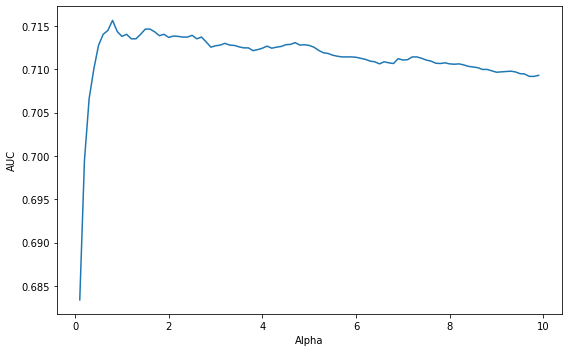

In [ ]:
_range = np.arange(0.1, 10, 0.1)
res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in _range], index=_range)

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.rcParams["figure.figsize"] = (8,5)
plt.plot(res)
plt.xlabel('Alpha')
plt.ylabel('AUC')
# plt.show()
plt.tight_layout()
plt.savefig('alpha_auc.svg')

In [ ]:
best_alpha

0.8

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
preds = probs[:, 1]
y_pred = np.where(preds >= 0.5, 1, 0)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 39.49%


Accuracy on real test set 

In [ ]:
test = pd.read_csv(base_path+'files/test_set_sentipolc16_gold2000.csv', escapechar='\\', header=None)
test.columns = ["idtwitter","subj","opos","oneg","iro","lpos","lneg", "top", "text"]
test['sentiment'] = test.apply(lambda x: 
                               0 if (x['lneg'] == 1 and x['lpos']==0) else 
                               2 if (x['lneg'] == 0 and x['lpos']==1) else 
                               1, axis=1)
test = test.dropna()

texts = np.array(test['text'])
texts = np.array([clean_tweet_lite(t) for t in texts])
texts = [x if x is not None else '' for x in texts]

y_test = np.array(test['sentiment'])

In [ ]:
# Calculate TF-IDF
X_test_tfidf = tf_idf.transform(texts)

In [ ]:
# Compute predicted probabilities
probs = nb_model.predict_proba(X_test_tfidf)

# Evaluate the classifier
preds = probs[:, 1]
y_pred = np.where(preds >= 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# BERT
https://skimai.com/fine-tuning-bert-for-sentiment-analysis/


https://nbviewer.org/github/omontasama/nlp-huggingface/blob/main/fine_tuning/huggingface_fine_tuning.ipynb

### Prepare data 

In [ ]:
### clean tweets text
df = start_df.copy()
df['text'] = df['text'].apply(lambda x: clean_tweet_lite(x))
df = df.dropna().drop_duplicates()

In [ ]:
### split train e validation
X = list(df['text'])
y = list(df['sentiment'])
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.15, random_state=123, shuffle=True, stratify=y)

In [ ]:
### one-hot encoding
enc = OneHotEncoder()
y_train = enc.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = enc.transform(np.array(y_val).reshape(-1, 1)).toarray()

In [ ]:
### get max len
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
all_tweets = np.concatenate([X_train, X_val])
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]
max_len = max([len(sent) for sent in encoded_tweets])
max_len

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

154

In [ ]:
# def bertTokenize(docs, tokenizer, max_len):
#   input_ids = []
#   attention_masks = []

#   for doc in docs:
#     bert_inp = tokenizer.encode_plus(doc, 
#                                      add_special_tokens = True, 
#                                      max_length = max_len, 
#                                      padding = 'max_length', 
#                                      return_attention_mask = True)
#     input_ids.append(bert_inp['input_ids'])
#     attention_masks.append(bert_inp['attention_mask'])


#   return input_ids, attention_masks

# ids_train, masks_train = bertTokenize(X_train, tokenizer, max_len)
# ids_val, masks_val = bertTokenize(X_val, tokenizer, max_len)

### Hyperparameters

In [ ]:
epochs = 1
batch_size = 16
loss = keras.losses.CategoricalCrossentropy()
output_function = 'softmax'

lr = 2e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# patience = 2
# stop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

### Costruzione rete

In [ ]:
def create_model(bert_model):

  # Inputs for token indices and attention masks
  input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input((max_len,), dtype=tf.int32, name='attention_mask')

  # bert model
  output = bert_model([input_ids, attention_mask]).last_hidden_state[:, 0, :]
  # output = bert_model([input_ids, attention_mask])[0]

  # # layer 0
  # output = tf.keras.layers.Dropout(0.2)(output)
  # output = tf.keras.layers.LSTM(256, return_sequences=False, kernel_initializer='glorot_uniform')(output)
  # output = tf.keras.layers.BatchNormalization()(output)
  # output = tf.keras.layers.Activation("relu")(output)

  # # layer 1
  # output = tf.keras.layers.Dropout(0.2)(output)
  # output = tf.keras.layers.Dense(256, kernel_initializer='glorot_uniform')(output)
  # output = tf.keras.layers.BatchNormalization()(output)
  # output = tf.keras.layers.Activation("relu")(output)

  # # layer 2
  # output = tf.keras.layers.Dropout(0.2)(output)
  # output = tf.keras.layers.Dense(256, kernel_initializer='glorot_uniform')(output)
  # output = tf.keras.layers.BatchNormalization()(output)
  # output = tf.keras.layers.Activation("relu")(output)

  # output
  output = layers.Dense(n_classes, activation=output_function)(output)

  # create and return model
  return models.Model(inputs=[input_ids, attention_mask], outputs=output)


  # # inputs
  # ids = layers.Input(shape=(max_len,), dtype='int32')
  # masks = layers.Input(shape=(max_len,), dtype='int32')

  # # # embedding
  # # embed = bert_model([ids, masks]).last_hidden_state[:, 0, :]

  # # # network
  # # dense = layers.Dense(512, activation='relu')(embed)
  # # dense = layers.Dropout(0.2)(dense)
  # # dense = layers.Dense(128, activation='relu')(dense)
  # # dense = layers.Dropout(0.2)(dense)
  # # dense = layers.Dense(n_classes, activation=output_function)(dense)
  # # return models.Model(inputs=[ids, masks], outputs=dense)
  

  # # embedding
  # embed = bert_model([ids, masks])[0]

  # # lstms
  # lstm1 = layers.LSTM(512, return_sequences=False, dropout=0.2)(embed)

  # # rest of network
  # dense1 = layers.Dense(256)(lstm1)
  # dropout1 = layers.Dropout(0.3)(dense1)
  # relu1 = layers.ReLU()(dropout1)
  
  # dense1 = layers.Dense(128)(relu1)
  # dropout1 = layers.Dropout(0.3)(dense1)
  # relu1 = layers.ReLU()(dropout1)

  # dense1 = layers.Dense(n_classes, activation=output_function)(relu1)

  # return models.Model(inputs=[ids, masks], outputs=dense1)



with strategy.scope():
  config = BertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  bert_model = TFBertModel.from_pretrained(model_name, config, num_labels=n_classes)#, from_tf=True)
  
  # # freeze
  # for layer in bert_model.layers:
  #     layer.trainable = False
  
  model = create_model(bert_model)

  model.compile(optimizer=optimizer, 
                loss=loss, 
                metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=False, show_layer_names=False, dpi=96)

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=96)

### Training

In [ ]:
def prepare_data(tokenizer, sentences, labels=None, batch_size=32): 
  encodings = tokenizer(sentences, truncation=True, padding='max_length', max_length=max_len, return_tensors="tf")
  if labels is not None:
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels)).batch(batch_size).prefetch(1)
  return tf.data.Dataset.from_tensor_slices(dict(encodings)).batch(batch_size).prefetch(1)

X = prepare_data(tokenizer, X_train, y_train, batch_size)
V = prepare_data(tokenizer, X_val, y_val, batch_size)

In [ ]:
training_history = model.fit(
    X, 
    # [ids_train, masks_train], 
    # y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=V,
    # validation_data=([ids_val, masks_val], y_val), 
    # callbacks=[stop_callback], 
) 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1613/1613 [==============================] - 244s 101ms/step - loss: 0.5285 - accuracy: 0.7856 - val_loss: 0.4477 - val_accuracy: 0.8177


In [ ]:
# for c in ['loss', 'val_loss']:
#   plt.plot(training_history.history[c], label=c)
# plt.legend()
# plt.show();

In [ ]:
# model.save_weights(base_path+"weights.h5", overwrite=True)

In [ ]:
# model.load_weights(base_path+"weights.h5")

### Validation results

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def classify(arr, threshold):
  if (np.argmax(arr) == 0) and (arr[0] >= threshold): #negative
    return 0
  elif (np.argmax(arr) == 2) and (arr[2] >= threshold): #positive
    return 2
  else:
    return 1

In [ ]:
# tmp = model.predict([ids_val, masks_val])
tmp = model.predict(V)
y_pred = enc.transform(np.array(np.argmax(tmp, axis=1)).reshape(-1, 1)).toarray()

print(accuracy_score(y_val, y_pred))
print()
print(classification_report(y_val, y_pred))

0.8177026136613222

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1486
           1       0.80      0.72      0.76      1549
           2       0.87      0.84      0.85      1518

   micro avg       0.82      0.82      0.82      4553
   macro avg       0.82      0.82      0.82      4553
weighted avg       0.82      0.82      0.82      4553
 samples avg       0.82      0.82      0.82      4553



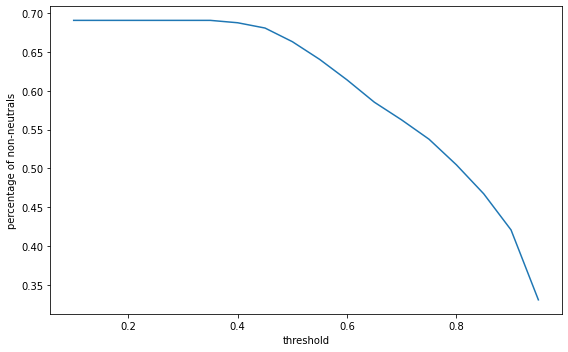

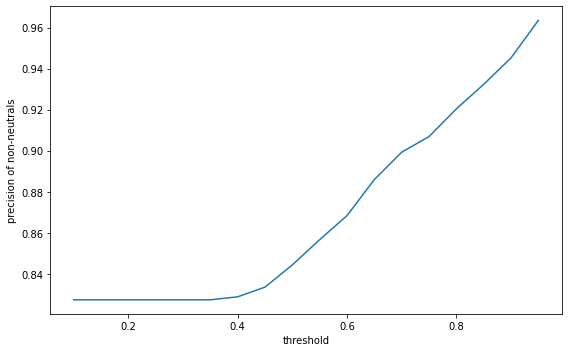

In [ ]:
x = list(np.arange(0.1, 1, 0.05))
rows = []

for t in x:
  tmp2 = [classify(tw, t) for tw in tmp]

  # percentage of non-neutrals
  count = pd.value_counts(tmp2).to_dict()
  if 0 not in count:
    count[0] = 0
  if 2 not in count:
    count[2] = 0
  perc = (count[0]+count[2])/(np.sum(list(count.values())))

  # precision of non-neutrals
  y_true = enc.inverse_transform(y_val).reshape(-1)
  result = list(zip(tmp2, y_true))
  result = [r for r in result if r[0] != 1]
  y_pred = [r[0] for r in result]
  y_true = [r[1] for r in result]
  acc = accuracy_score(y_true, y_pred)
  
  rows.append((perc,acc))

tmp_df = pd.DataFrame(rows, index=x, columns=['percentage', 'precision'])


plt.rcParams["figure.figsize"] = (8,5)
for c in tmp_df.columns: 
  plt.plot(tmp_df[c])
  plt.xlabel('threshold')
  plt.ylabel(c+' of non-neutrals')
  plt.tight_layout()
  plt.savefig(base_path+c+'_threshold.svg')
  plt.show();

In [ ]:
texts = np.array([
                 "io vi ammazzo tutti merde morte sangue violenza", 
                 "oggi è proprio una bella giornata splendente, viva la vita", 
                 "#Milano è tornato il #SaloneDelMobile, dopo uno stop di 18 mesi dovuto alle restrizioni legate alla pandemia. All'inaugurazione ha partecipato anche il Presidente Mattarella. #supersalone21 https://t.co/kthM9Y9YzZ", 
                 "banana", 
                 'Fuorisalone 2019: gli eventi di moda e gli appuntamenti da non perdere a Milano https://t.co/PqbseSK69w', 
                 '@SkyTG24: Milano, al via la 57esima edizione del Salone del Mobile https://t.co/e0mf6k5Z3B',
                 "Porta Venezia in Design 2019: un percorso che unisce design e food&amp;wine: Tutti gli eventi 2019 del circuito Porta Venezia in Design che unisce il design al food&amp;wine con un focus particolare sullo stile Liberty che caratterizza l'intera zona di Porta… https://t.co/ohKwpKdxj6 https://t.co/Zz20CyYaIM",
                 "@terminologia: #itanglese al #fuorisalone:\rcorte del food, food court, truckerS del cucù truck, eV-now… 🙄 \rMa #parlacomemangi (cibo!) e…", 
                 "Venerdi 12 Aprile 2019\nIn occasione del Salone del Mobile\n\nLISTA TRIO ha l'onore di invitarti presso l' Urban Garden del NYX Hotel Milan\n\nNuovissimo Hotel Lifestyle nel vivace centro di Milano !\n-\nCHILLOUT DELUXE... https://t.co/JoBzS7527D",
                 'Sincronizzate le agende e non perdetevi neanche un appuntamento di questo Salone del Mobile https://t.co/BJDRfwbkmz https://t.co/qG4kG2fQOY',
                 ])
texts = np.array([clean_tweet_lite(t) for t in texts])
print(texts)
print()

tmp = prepare_data(tokenizer, list(texts))
tmp_pred = model.predict(tmp)
# ids_tmp, masks_tmp = bertTokenize(texts, tokenizer, max_len)
# tmp_pred = model.predict([ids_tmp, masks_tmp])

print(tmp_pred)
print()

print([classify(p, 0.7) for p in tmp_pred])

['io vi ammazzo tutti merde morte sangue violenza'
 'oggi è proprio una bella giornata splendente, viva la vita'
 "#milano è tornato il #salonedelmobile, dopo uno stop di 18 mesi dovuto alle restrizioni legate alla pandemia. all'inaugurazione ha partecipato anche il presidente mattarella. #supersalone21"
 'banana'
 'fuorisalone 2019: gli eventi di moda e gli appuntamenti da non perdere a milano'
 '@user: milano, al via la 57esima edizione del salone del mobile'
 "porta venezia in design 2019: un percorso che unisce design e food&wine: tutti gli eventi 2019 del circuito porta venezia in design che unisce il design al food&wine con un focus particolare sullo stile liberty che caratterizza l'intera zona di porta…"
 '@user: #itanglese al #fuorisalone: corte del food, food court, truckers del cucù truck, ev-now… 🙄 ma #parlacomemangi (cibo!) e…'
 "venerdi 12 aprile 2019 in occasione del salone del mobile lista trio ha l'onore di invitarti presso l' urban garden del nyx hotel milan nuovissimo

### Test sentpolc ita

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
test = pd.read_csv(base_path+'files/test_set_sentipolc16_gold2000.csv', escapechar='\\', header=None)
test.columns = ["idtwitter","subj","opos","oneg","iro","lpos","lneg", "top", "text"]
test['sentiment'] = test.apply(lambda x: 
                               0 if (x['lneg'] == 1 and x['lpos']==0) else 
                               2 if (x['lneg'] == 0 and x['lpos']==1) else 
                               1, axis=1)
test = test.dropna()

texts = np.array(test['text'])
texts = np.array([clean_tweet_lite(t) for t in texts])
texts = [x if x is not None else '' for x in texts]

y_test = np.array(test['sentiment'])

# ids_tmp, masks_tmp = bertTokenize(texts, tokenizer, max_len)
# ids_tmp = np.asarray(ids_tmp).astype('float32')
# masks_tmp = np.asarray(masks_tmp).astype('float32')

tmp = prepare_data(tokenizer, list(texts))

In [ ]:
# tmp_pred = model.predict([ids_tmp, masks_tmp])
tmp_pred = model.predict(tmp)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
y_pred = np.argmax(tmp_pred, axis=1)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.618
              precision    recall  f1-score   support

           0       0.71      0.39      0.50       577
           1       0.64      0.80      0.71      1054
           2       0.47      0.47      0.47       369

    accuracy                           0.62      2000
   macro avg       0.61      0.55      0.56      2000
weighted avg       0.63      0.62      0.60      2000



### Classify dataset

In [ ]:
! mkdir files
! cp "drive/MyDrive/Università/5/Stage/tweets-analysis/TweetsSentiment.py" .
! cp "drive/MyDrive/Università/5/Stage/tweets-analysis/TweetsUtils.py" .

In [ ]:
from TweetsUtils import *
from datetime import datetime, timedelta

In [ ]:
def read_tweets(years):
    tweets, users, places = [], [], []
    for year in years:
        tmp_tweets, tmp_users, tmp_places = read_tweets_files(year)
        tweets += tmp_tweets
        users += tmp_users
        places += tmp_places
    return tweets, users, places



def read_tweets_files(year):
    tmp_path = base_path + 'tweets/mdw' + str(year)[-2:] + '_tweets/'
    tweets_filename = tmp_path + 'mdw' + str(year)[-2:] + '_tweets_contents.json'
    users_filename = tmp_path + 'mdw' + str(year)[-2:] + '_tweets_users.json'
    places_filename = tmp_path + 'mdw' + str(year)[-2:] + '_tweets_places.json'
    
    tmp_tweets = read_file(tweets_filename)
    tmp_users = read_file(users_filename)
    tmp_places = read_file(places_filename)

    for tw in tmp_tweets:
        tw['datetime'] = datetime.strptime(tw['datetime'], '%Y-%m-%d %H:%M:%S')
    
    # tmp_tweets = center_week(tmp_tweets, year)
    
    return tmp_tweets, tmp_users, tmp_places

In [ ]:
tweets, users, places = read_tweets(years)

print('TOT:', len(tweets), 'tweets')
print('TOT:', len(users), 'users')
print('TOT:', len(places), 'places')

TOT: 71061 tweets
TOT: 30182 users
TOT: 286 places


In [ ]:
unique_texts = select_fields(tweets, ['text'], as_list=True, unique=True)
tmp = pd.DataFrame({'original': unique_texts})
tmp['clean'] = tmp['original'].apply(lambda x: clean_tweet_lite(x))
tmp = tmp.drop_duplicates('clean')

In [ ]:
unique_texts = list(tmp['original'])
texts = list(tmp['clean'])

In [ ]:
def bertTokenize(docs, tokenizer, max_len):
  input_ids = []
  attention_masks = []

  for doc in docs:
    bert_inp = tokenizer.encode_plus(doc, 
                                     add_special_tokens = True, 
                                     max_length = max_len, 
                                     padding = 'max_length', 
                                     truncation = True, 
                                     return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

  input_ids = np.array(input_ids, dtype=object)
  attention_masks = np.array(attention_masks, dtype=object)

  input_ids = np.asarray(input_ids).astype('float32')
  attention_masks = np.asarray(attention_masks).astype('float32')

  return input_ids, attention_masks


# tokenizer = AutoTokenizer.from_pretrained(model_name)
# ids_tmp, masks_tmp = bertTokenize(texts, tokenizer, max_len)

In [ ]:
# pred = model.predict([ids_tmp, masks_tmp])
tmp = prepare_data(tokenizer, list(texts))
pred = model.predict(tmp)

In [ ]:
d = {unique_texts[i]: classify(pred[i], threshold=0.9) for i in range(len(pred))}
pd.value_counts(list(d.values()))

In [ ]:
sent = 0
tmp = pd.DataFrame()
tmp['text'] = list(d.keys())
tmp['sentiment'] = list(d.values())
list(tmp[tmp['sentiment']==sent].sample(30)['text'])

In [ ]:
d = [{
    'text': unique_texts[i], 
    'positive': pred[i][2], 
    'neutral': pred[i][1], 
    'negative': pred[i][0], 
  }
  for i in range(len(pred))]

tmp = pd.DataFrame(d)
tmp.to_csv(base_path+'files/sentiment_results.json', index=False)

# Final results

In [ ]:
data = pd.read_csv(base_path+'files/sentiment_results.json')

validation threshold

In [ ]:
x = list(np.arange(0.1, 1, 0.05))
rows = []

for t in x:
  tmp2 = [classify(tw, t) for tw in tmp]

  # percentage of non-neutrals
  count = pd.value_counts(tmp2).to_dict()
  if 0 not in count:
    count[0] = 0
  if 2 not in count:
    count[2] = 0
  perc = (count[0]+count[2])/(np.sum(list(count.values())))

  # precision of non-neutrals
  y_true = enc.inverse_transform(y_val).reshape(-1)
  result = list(zip(tmp2, y_true))
  result = [r for r in result if r[0] != 1]
  y_pred = [r[0] for r in result]
  y_true = [r[1] for r in result]
  acc = accuracy_score(y_true, y_pred)
  
  rows.append((perc,acc))

tmp_df = pd.DataFrame(rows, index=x, columns=['percentage', 'precision'])


plt.rcParams["figure.figsize"] = (8,5)
for c in tmp_df.columns: 
  plt.plot(tmp_df[c])
  plt.xlabel('threshold')
  plt.ylabel(c+' of non-neutrals')
  plt.show();

stanza

In [ ]:
! pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 7.5 MB/s 
     |████████████████████████████████| 216 kB 86.5 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=a8f7e773b2692d672aaf2f556a405ed8e882aee6426a8bbf6711318c2bde6ae1
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [ ]:
import stanza
stanza.download('it')

INFO:stanza:Downloading default packages for language: it (Italian) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


In [ ]:
nlp = stanza.Pipeline('it', processors='lemma,tokenize,ner')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: it (Italian):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| lemma     | combined |
| ner       | fbk      |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: lemma
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
def get_entities(text):
    # tokenization, lemmatization, ner
    processed = nlp(text)

    # reformat entities
    entities = [e.to_dict() for e in processed.entities]
    entities = select_fields(entities, ['text', 'type'])
    
    return entities

In [ ]:
def entity_cleaning(text): 
  # remove links
  regex = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
  text = re.sub(regex, '', text)

  # fix start of tweet
  if text.startswith('rt '): 
    text = text[3:]

  # replace html chars
  text = BeautifulSoup(text).get_text()
  text = text.replace('\x92', '\'') # quotes
  # text = text.replace('&lt;', '<').replace('&gt;', '>').replace('&amp;', '&').replace('&#39;', '\'').replace('&#039;', '\'')
  text = text.replace('[', '(').replace(']', ')') # brackets

  # replace users mentions
  text = ' '.join(re.sub("(@[A-Za-z0-9_]+)", "@user", text).split())

  # fix punctuation
  text = text.replace(' . ', '. ').replace(' , ', ', ').replace(' : ', ': ').replace(' ; ', '; ').replace(' ? ', '? ').replace(' ! ', '! ')

  # fix whitespaces
  text = ' '.join(text.split())

  return text

In [ ]:
tmp = pd.DataFrame(tweets)
tmp = tmp[['datetime', 'text']]
tmp = tmp.drop_duplicates('text')
tmp = tmp.set_index('text').join(data.set_index('text')).reset_index().dropna().reset_index(drop=True)
tmp['datetime'] = pd.to_datetime(tmp['datetime'])
tmp = tmp.set_index('datetime')
tmp

,text,positive,neutral,negative
datetime,,,,
2018-04-21 09:45:01,""" ... i progetti estivi che vedranno coinvolto...",0.127370,0.850391,0.022239
2021-09-06 10:22:05,""" @LaFeltrinelli di Piazza Piemonte, invece, ...",0.021229,0.942965,0.035806
2018-04-18 14:32:57,""" @ed_eleuthera: Consigli di lettura per... da...",0.038491,0.950115,0.011395
2022-06-05 12:22:12,""" @reasonedart: 'Via Paolo Sarpi, 6.\n\nIn occ...",0.006586,0.991195,0.002219
2021-09-05 11:50:36,""" Questo è un punto di riferimento mondiale in...",0.089579,0.865107,0.045314
...,...,...,...,...
2019-04-11 10:56:42,🧩🚪🖼🎐\n\n☝️🙂🗯 ..#SaloneDelMobile \n\n☝️😃🗯 ..b...,0.872228,0.114609,0.013163
2019-04-11 10:58:25,🧩🚪🛌🎐\n\n☝️😃🗯 ..e 2 settimane che vedo di...,0.194983,0.716793,0.088224
2021-09-07 06:10:02,"🪑 A #Milano, l'evento che anima la città duran...",0.005057,0.990543,0.004400


In [ ]:
threshold = 0.7

neg = tmp[(tmp['negative']>=threshold)].copy()
neg['clean'] = neg['text'].apply(lambda x: entity_cleaning(x))
neg['full_clean'] = neg['text'].apply(lambda x: clean_tweet_full(x))

pos = tmp[(tmp['positive']>=threshold)].copy()
pos['clean'] = pos['text'].apply(lambda x: entity_cleaning(x))
pos['full_clean'] = pos['text'].apply(lambda x: clean_tweet_full(x))

n = neg['text'].resample('Y').count()
p = pos['text'].resample('Y').count()

In [ ]:
n2 = list(n)
p2 = list(p)
del n2[2]
del p2[2]
[n2[i]/(n2[i]+p2[i]) for i in range(len(n2))], [p2[i]/(n2[i]+p2[i]) for i in range(len(n2))]

([0.25418060200668896,
  0.37059859154929575,
  0.39344262295081966,
  0.5698324022346368],
 [0.745819397993311,
  0.6294014084507042,
  0.6065573770491803,
  0.4301675977653631])

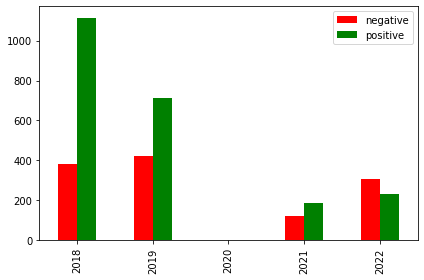

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
fig = pd.DataFrame({'negative': list(n), 'positive': list(p)}, index=[2018,2019,2020,2021,2022]).plot(kind='bar', color=['r', 'g'])

plt.tight_layout()
plt.savefig(base_path+'sentiment_years.svg')

In [ ]:
threshold = 0.7

neg = data[(data['negative']>=threshold)].copy()
neg['clean'] = neg['text'].apply(lambda x: entity_cleaning(x))
neg['full_clean'] = neg['text'].apply(lambda x: clean_tweet_full(x))

pos = data[(data['positive']>=threshold)].copy()
pos['clean'] = pos['text'].apply(lambda x: entity_cleaning(x))
pos['full_clean'] = pos['text'].apply(lambda x: clean_tweet_full(x))

len(neg), len(pos)

(1227, 2248)

In [ ]:
entities_raw = get_entities('.\n'.join(list(pos['clean'])))
entities_tot = [u['text'].lower() for u in entities_raw if not (u['text'].startswith('#')) and not (u['text'].startswith('@'))]

In [ ]:
for t in ['PER', 'LOC', 'ORG']:
  ent = [u['text'].lower() for u in entities_raw if not (u['text'].startswith('#')) and not (u['text'].startswith('@')) and (u['type']==t)]
  print('\n',t)
  print(pd.value_counts(ent).head(15))


 PER
mattarella           6
stefano boeri        6
scavolini            5
marras               5
ballarini            5
enrico               5
leonardo             4
andrea signoretto    4
di maio              4
alex chinneck        4
antonio marras       4
salvini              4
peter pichler        3
luigi di maio        3
tenoha               3
dtype: int64

 LOC
milano                   469
italia                    26
italy                     18
lambrate                   9
via tortona                8
palazzo litta              7
rho                        6
statale                    6
brera                      5
isola design district      5
tortona                    4
giappone                   4
brindisi                   3
ivrea                      3
via durini                 3
dtype: int64

 ORG
italia                16
milan                  9
milano design week     4
governo                4
confapi matera         3
poliform               3
nft                    3
c

In [ ]:
entities_raw = get_entities('.\n'.join(list(neg['clean'])))
entities_tot = [u['text'].lower() for u in entities_raw if not (u['text'].startswith('#')) and not (u['text'].startswith('@'))]

In [ ]:
for t in ['PER', 'LOC', 'ORG']:
  ent = [u['text'].lower() for u in entities_raw if not (u['text'].startswith('#')) and not (u['text'].startswith('@')) and (u['type']==t)]
  print('\n',t)
  print(pd.value_counts(ent).head(15))


 PER
conte             15
salvini            6
giuseppe conte     5
gesù               4
berlusconi         4
bruno              4
madonna            4
di maio            3
beppe sala         2
maio               2
giovanni           2
miky               2
verdini            2
bono               2
hernest kumm       2
dtype: int64

 LOC
milano          193
italia           19
rho              10
europa            7
roma              6
brera             4
lambrate          3
libia             3
russia            3
duomo             3
torino            3
napoli            3
via tortona       3
piazza duomo      2
siria             2
dtype: int64

 ORG
ikea                                7
brexit                              4
italia                              4
governo                             4
atm                                 2
trenord                             2
atac                                2
prefettura                          2
tg                                  2

In [ ]:
for t in ['PER', 'LOC', 'ORG']:
  ent = [u['text'].lower() for u in entities_raw if not (u['text'].startswith('#')) and not (u['text'].startswith('@')) and (u['type']==t)]
  print('\n',t)
  tmp = pd.value_counts(ent).head(15)
  plt.bar(tmp.index, list(tmp))
  plt.show();

Wordcloud

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [ ]:
corpus = [
    '.\n'.join(list(pos['full_clean'])),
    '.\n'.join(list(neg['full_clean'])),
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

matrix = pd.DataFrame(X.todense().T, columns=['pos', 'neg'], index=vectorizer.get_feature_names_out())
matrix['diff'] = matrix['pos'] - matrix['neg']

In [ ]:
matrix.rename(index={
    'cazzo':'c***o', 
    'merda': 'm***a', 
    'minchia': 'm*****a', 
    'coglioni': 'c******i', 
    'vaffanculo': 'v********o', 
}, inplace=True)

In [ ]:
for s in stopwords_list:
  matrix = matrix[matrix.index!=s]

In [ ]:
matrix.sort_values(by='pos', ascending=False)#.head(12)

,pos,neg,diff
salone,0.494574,0.539358,-0.044784
milano,0.385625,0.157038,0.228587
mobile,0.369856,0.409472,-0.039616
grazie,0.233668,0.006604,0.227064
fuorisalone,0.228651,0.179786,0.048865
...,...,...,...
ragioneresti,0.000000,0.001031,-0.001031
fruito,0.000000,0.001031,-0.001031
frustare,0.000000,0.001031,-0.001031
concedere,0.000000,0.001031,-0.001031


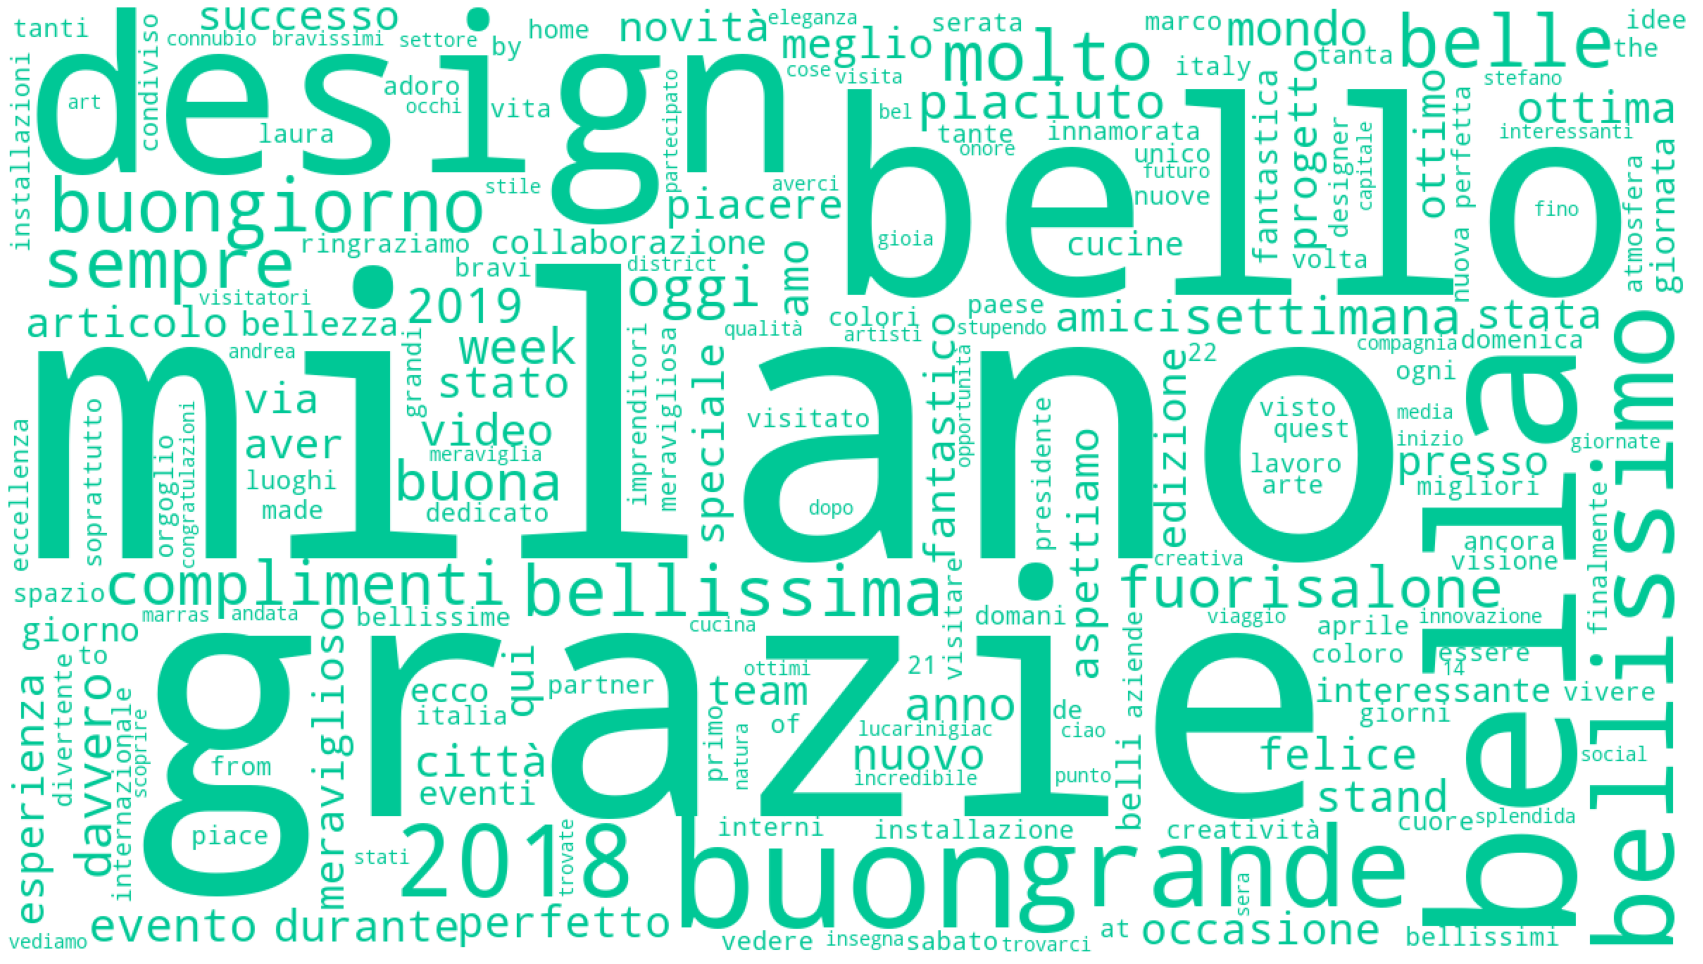

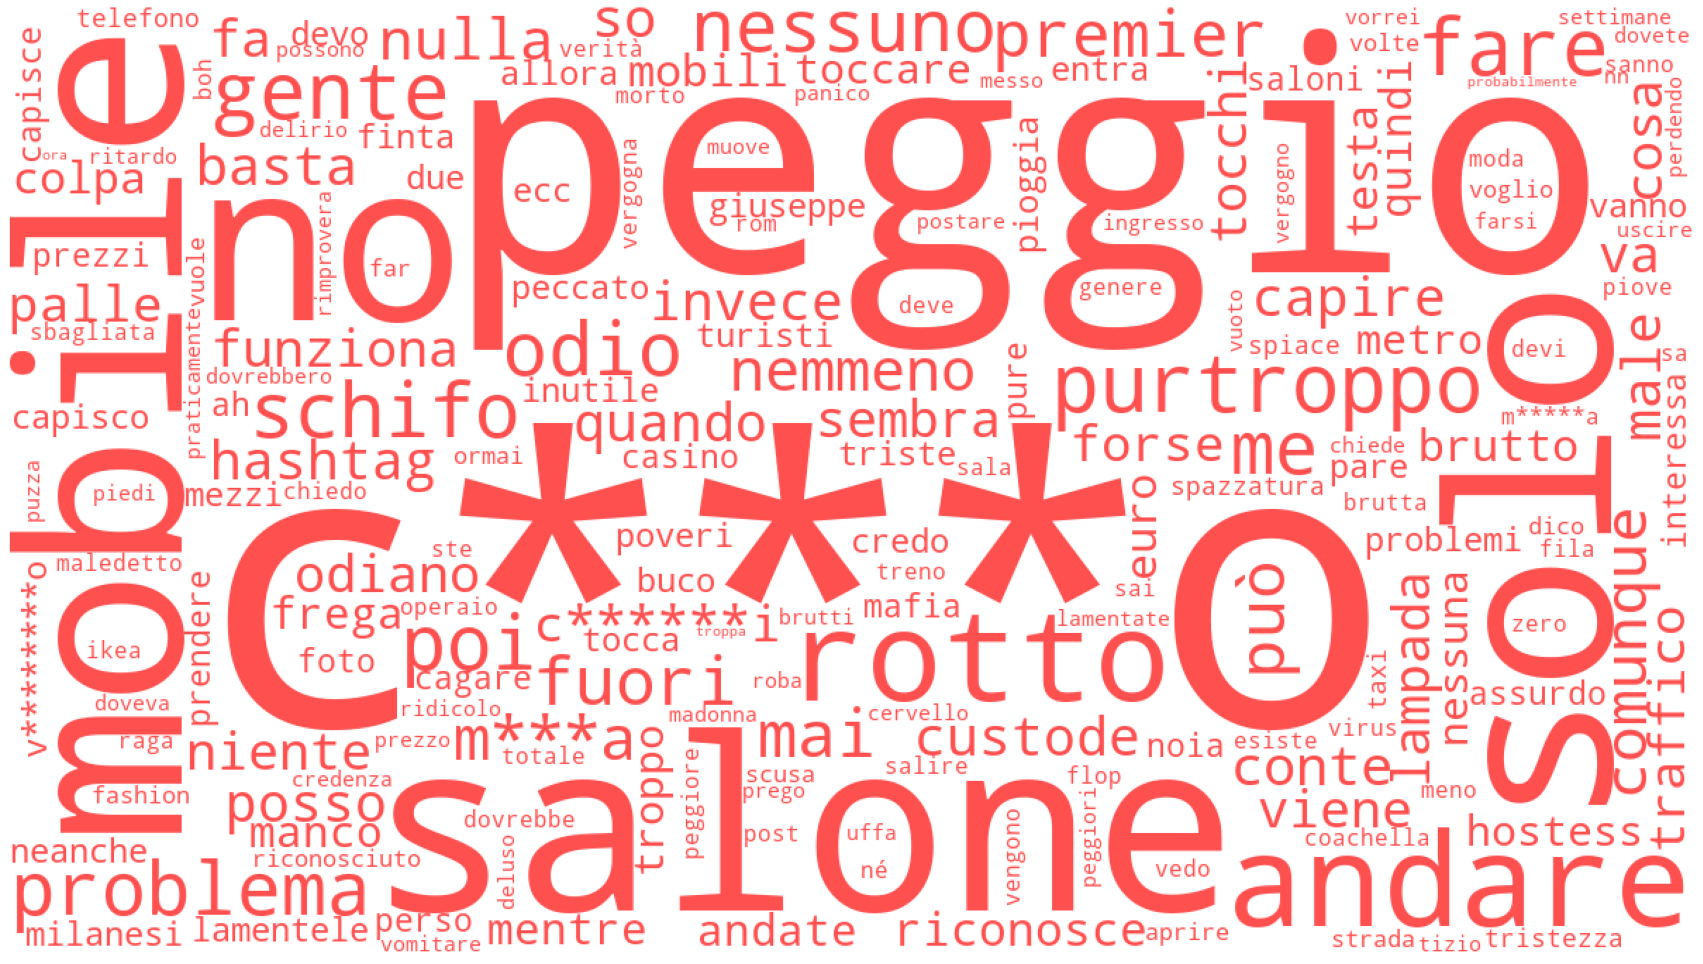

In [ ]:
# positive
tmp = matrix['diff'].copy()
tmp = np.abs(tmp[tmp>0])
wordcloud = WordCloud(width=1200, height=675, background_color="white", color_func=lambda *args, **kwargs: (0,200,150)).generate_from_frequencies(tmp)

fig = plt.figure(figsize=(24,13.5), num=1, clear=True)
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[], frameon=False)
plt.imshow(wordcloud)
plt.show();


# negative
tmp = matrix['diff'].copy()
tmp = np.abs(tmp[tmp<0])
del tmp['non']
wordcloud = WordCloud(width=1200, height=675, background_color="white", color_func=lambda *args, **kwargs: (255,80,80)).generate_from_frequencies(tmp)

fig = plt.figure(figsize=(24,13.5), num=1, clear=True)
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[], frameon=False)
plt.imshow(wordcloud)
plt.show();